# Vegetation Phenology <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on deriving phenology from NDVI time-series](https://www.usgs.gov/land-resources/eros/phenology/science/deriving-phenological-metrics-ndvi?qt-science_center_objects=0#qt-science_center_objects)

## Description

This notebook demonstrates how to calculate vegetation phenology statistics using the DE Africa function [xr_phenology](../Scripts/deafrica_temporal_statistics.py).  To detect changes in plant life for Sentinel-2, the script uses either the **Normalized Difference Vegetation Index (NDVI)** or the **Enhanced Vegetation Index (EVI)**, which are common proxies for vegetation growth and health.

The outputs of this notebook can be used to assess spatio-temporal differences in the growing seasons of agriculture fields or native vegetation.

This notebook demonstrates the following steps:

1. Load cloud-masked Sentinel 2 data for an area of interest.
2. Calculate a vegetation proxy index (NDVI or EVI).
3. Generate a zonal time series of vegetation health
4. Complete and smooth the vegetation timeseries to remove gaps and noise.
5. Calculate phenology statistics on a simple 1D vegetation time series
6. Calculate per-pixel phenology statistics
7. Optional: Calculating generic temporal statistics usng the hdstats library

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [119]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
from datacube.utils import geometry
import numpy as np
import pandas as pd
import geopandas as gpd
import sys
import xarray as xr
import datetime as dt
import os

sys.path.append('../../Scripts')
from deafrica_datahandling import load_ard
from deafrica_bandindices import calculate_indices
from deafrica_plotting import map_shapefile, rgb
import deafrica_temporal_statistics as ts
from deafrica_dask import create_local_dask_cluster
from deafrica_spatialtools import xr_rasterize
from deafrica_classificationtools import HiddenPrints

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)


/env/lib/python3.6/site-packages/datacube/storage/masking.py:8: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


## Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. For an introduction to using Dask with Digital Earth Africa, see the Dask notebook.

In [2]:
create_local_dask_cluster(spare_mem='1Gb')

Client Scheduler: tcp://127.0.0.1:38399 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 15.11 GB


### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `'NDVI'` or `'EVI'`
* `lat`: The central latitude to analyse (e.g. `-10.6996`).
* `lon`: The central longitude to analyse (e.g. `35.2708`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The year range to analyse (e.g. `('2019-01', '2019-06')`).



In [3]:
# Set the vegetation proxy to use
veg_proxy = 'EVI'

product = 's2_l2a'

shapefile='data/Ruko_conservancy.geojson'

# Set the range of dates for the analysis
time_range = ('2017-01', '2020-12-30')

min_gooddata = 0.15

resolution = (-20,20)

dask_chunks = {'x':750, 'y':750}


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app='Vegetation_phenology')

## View the region of interest
The next cell will display the selected area on an web map.

In [5]:
#First open the shapefile using geopandas
gdf = gpd.read_file(shapefile)

In [6]:
map_shapefile(gdf, attribute='ConsrvName')

Label(value='')

Map(center=[0.648084104061088, 36.12258148195494], controls=(ZoomControl(options=['position', 'zoom_in_text', …

## Load cloud-masked Sentinel-2 data

The first step is to load Sentinel-2 data for the specified area of interest and time range. 
The `load_ard` function is used here to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

The cell directly below will create a query object using the first geometry in the shapefile, along with the parameters we defined in the Analysis Parameters section above.

In [7]:
# Create a reusable query
geom = geometry.Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)

query = {
    "geopolygon": geom,
    'time': time_range,
    'measurements': ['red','blue','nir','green','swir_1','SCL'],
    'resolution': resolution,
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}


Load available data from S2:

In [8]:
ds = load_ard(
    dc=dc,
    products=['s2_l2a'],
    dask_chunks=dask_chunks,
    min_gooddata=min_gooddata,
    **query,
)

print(ds)

../../Scripts/deafrica_datahandling.py:240: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 227 out of 260 time steps with at least 15.0% good quality pixels
Applying pixel quality/cloud mask
Returning 227 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 227, x: 607, y: 1194)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-02T08:07:11 ... 2020-12-27T08:...
  * y            (y) float64 9.461e+04 9.459e+04 ... 7.077e+04 7.075e+04
  * x            (x) float64 3.479e+06 3.479e+06 ... 3.491e+06 3.491e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 750, 607), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 750, 607), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 750, 607), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 750, 607), meta=np.ndarray>
    swir_1   

## Cloud Buffering

The cloud masking data for Sentinel-2 is less than perfect, and missed cloud in the data greatly impacts vegetation  calculations. Below we will buffer the cloud-masking bands in an attempt to improve the masking of poor quality data.

In [9]:
import odc.algo

#Extract boolean mask
mask = odc.algo.enum_to_bool(ds.SCL, 
                             categories=['cloud shadows', 'cloud medium probability',
                                         'cloud high probability', 'thin cirrus'])
                             
# Close mask to remove small holes in cloud, open mask to 
# remove narrow false positive cloud, then dilate
mask = odc.algo.binary_closing(mask, 2)
mask_cleaned = odc.algo.mask_cleanup(mask, r=(2, 10))

# Add new mask as nodata pixels
ds_clean = odc.algo.erase_bad(ds, mask_cleaned)


## Mask the satellite data with shape

In [10]:
#create mask
mask = xr_rasterize(gdf,ds)

#mask data
ds = ds.where(mask)

#remove SCL since we don't need it anymore
ds = ds.drop('SCL')

#convert to float 32 to conserve memory
ds=ds.astype(np.float32)

Rasterizing to match xarray.DataArray dimensions (1194, 607)


## Calculate vegetation and water indices

In [11]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds, index=[veg_proxy, 'MNDWI'], collection='s2')

#drop bands no-longer needed (save memory)
ds = ds.drop(['red','green','nir','blue','swir_1'])

## Prepare data for analysis

Remove any NaN or infinite values, mask water, remove any outliers in the vegetation index.  We then reduce the data to a 1D timeseries by calculting the mean across the x and y dimensions.  

We will also 'compute' the data on the dask cluster to speed up calculations later on. This step will take 5-10mins to run since we are now computing everything that came before.

In [12]:
# remove any infinite values
ds = ds.where(xr.ufuncs.isfinite(ds))

# mask water
ds = ds.where(ds.MNDWI < 0)

#remove outliers (if EVI greater than 1.0, set to NaN) 
ds['EVI'] = xr.where(ds['EVI']>1.0, np.nan, ds['EVI'])

# create 1D line plots
veg = ds[veg_proxy].mean(['x', 'y']).compute()

## Smooth and interpolate time series

Due to many factors (e.g. cloud obscuring the region, missed cloud cover in the SCL layer) the data will be gappy and noisy. Here, we will smooth and interpolate the data to ensure we working with a consistent time-series.

To do this we take two step:

1. Resample the data to fortnightly time-steps using the monthly median
2. Calculate a rolling mean with a window of 4 steps

In [76]:
resample_period='2W'
window=4

veg_smooth=veg.resample(time=resample_period).median().rolling(time=window, min_periods=1).mean()

## Plot the entire time-series

Text(0.5, 1.0, 'EVI time-series, year start/ends marked with vertical lines')

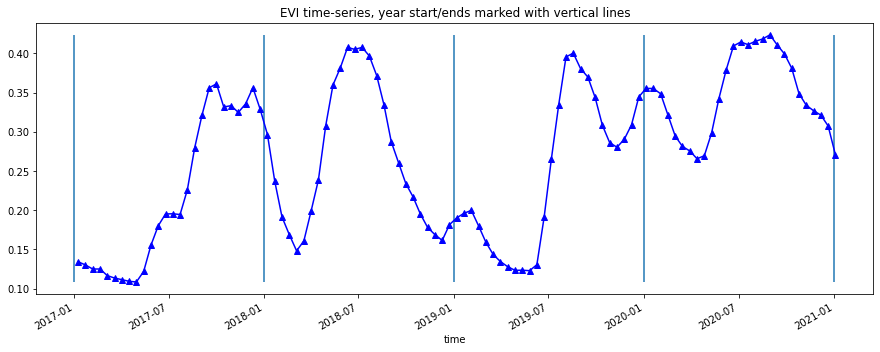

In [77]:
veg_smooth.plot.line('b-^', figsize=(15,5))
_max=veg_smooth.max()
_min=veg_smooth.min()
plt.vlines(np.datetime64('2017-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2018-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2019-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2020-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2021-01-01'), ymin=_min, ymax=_max)
plt.title(veg_proxy+' time-series, year start/ends marked with vertical lines');

## Compute basic phenology statistics

In [142]:
basic_pheno_stats = ['SOS','vSOS','POS', 'vPOS','EOS', 'vEOS']
method_sos = 'first'
method_eos = 'last'

In [143]:
#get list of years in ts to help
years_int=[y[0] for y in years]

#store results in dict
pheno_results = {}

#loop through years and calculate phenology
for year in years_int[0:-1]:
    print(year)
    #select year
    da = dict(years)[year]
    #calculate stats
    with HiddenPrints():
        stats=ts.xr_phenology(
                da,
                method_sos=method_sos,
                method_eos=method_eos,
                stats=basic_pheno_stats,
                complete=None,
                smoothing=None,
                    )
    #add results to dict    
    pheno_results[str(year)] = stats

2017
2018
2019
2020


## Annotate phenology on plot

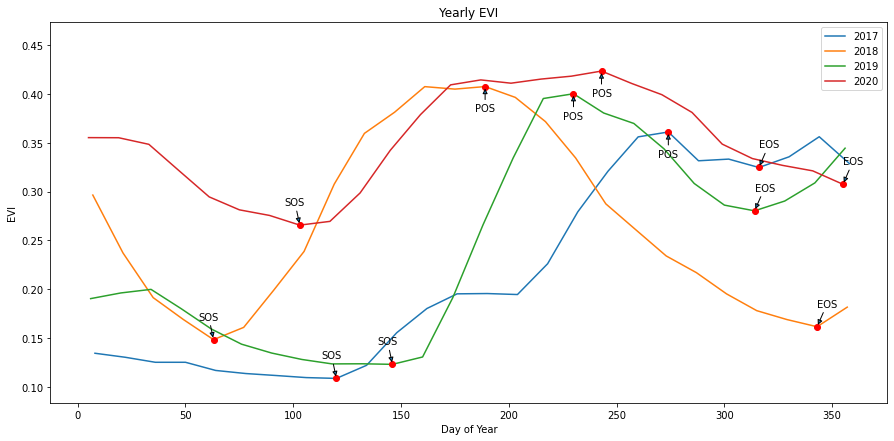

In [144]:
# find all the years to assist with plotting
years=veg_smooth.groupby('time.year')

fig, ax = plt.subplots()
fig.set_size_inches(15,7)
for year, y in zip(years, years_int[:-1]):
    #the groupby and mean below doesn't actually do anything, expect allow
    #the plots to be on the same x-axis. i.e. veg-data isn't modified, just time units
    year[1].groupby('time.dayofyear').mean().plot(ax=ax, label=year[0])
    # Use DOY results to create a datetime object
    year = str(ds.time.dt.year.values[0]) + " "
    eos_dt = pheno_results[str(y)].EOS.values
    sos_dt = pheno_results[str(y)].SOS.values
    pos_dt = pheno_results[str(y)].POS.values

    #add start of season
    ax.plot(sos_dt, pheno_results[str(y)].vSOS, 'or')
    ax.annotate('SOS',
                xy=(sos_dt, pheno_results[str(y)].vSOS.values),
                xytext=(-15, 20),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))

    #add end of season
    ax.plot(eos_dt, pheno_results[str(y)].vEOS, 'or')
    ax.annotate('EOS',
                xy=(eos_dt, pheno_results[str(y)].vEOS.values),
                xytext=(0, 20),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))

    #add peak of season
    ax.plot(pos_dt, pheno_results[str(y)].vPOS, 'or')
    ax.annotate('POS',
                xy=(pos_dt, pheno_results[str(y)].vPOS.values),
                xytext=(-10, -25),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))
ax.legend()
plt.ylim(_min-0.025,_max.values+0.05)
plt.xlabel('Day of Year')
plt.ylabel(veg_proxy)
plt.title('Yearly '+ veg_proxy);

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [145]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-03-17'